In [40]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from matplotlib.image import NonUniformImage
import cv2
from itertools import zip_longest
import numpy as np
import cv2
import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [41]:
image_file = 'C:/Users/bits/Desktop/PS1_DATASET/OUTEX/Outex-TC-00010/images/000000.bmp'
img_bgr = cv2.imread(image_file)
height, width, channel = img_bgr.shape
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
print(img_gray)
img_gray = img_gray/255
cv2.imshow('img_gray',img_gray)
cv2.waitKey(0) 
  
#closing all open windows 
cv2.destroyAllWindows() 

[[ 82  82  91 ...  77  84  93]
 [100  97  99 ...  89  96 100]
 [103  98 101 ...  79  98 106]
 ...
 [ 76  80  89 ... 100  98  95]
 [ 88  97 102 ...  97  97  99]
 [103 120 120 ... 114 118 110]]


In [42]:
def get_riu2_mappings(p: int):
    """
    Generate a mapping table from an LBP value to a riu2 bin.
    To summarise, riu2 classifies uniform LBPs (defined as U<=2, where U is the number of bitwise transitions) into p+1
    groups, and then puts non-uniform patterns into one group.
    """
    # Number of distinct LBP patterns to create mappings for
    size = 2 ** p

    # Create riu2 mappings table of unsigned integers
    mappings = [0] * size

    for i in range(0, size):
        # Convert i to representation as binary string
        binary = format(i, '08b')
        # Bit shift left by taking first digit and concatenating to end
        binary_lshift = binary[1:] + binary[:1]

        # Effectively, take each digit of 'binary' and 'binary_lshift' and check if there is a value difference.
        # When this is the case, it indicates a bitwise transition from 0 to 1 or 1 to 0.
        U, sum_bits = 0, 0
        for j in range(0, p):
            bit = binary[j]
            bit_lshift = binary_lshift[j]

            if bit != bit_lshift:
                # bitwise transition
                U += 1
            sum_bits += int(bit)  # Keep sum of bits

        if U <= 2:
            # Put uniform patterns into one of p+1 groups
            # Eg: If p=4 we have a group for every sum of bits. 0000 = 0, 0001 = 1, 0011 = 2, 0111 = 3, 1111 = 4
            # Forming 5 separate groups
            mappings[i] = sum_bits
        else:
            # Put non-uniform patterns into one group
            mappings[i] = p + 1  # p + 1 case

    return mappings

In [43]:
# w_r1 = [3, 5, 7, 9]
# r1 = [2, 4, 6, 8]
w_r1 = [3]
r1 = [2]
p = 8
w_center = 3
w_c = w_center
padding = 0
w_r1 = w_r1  # 'w_r1', local patch size for first r' kernel.
r_wr_scales = list(zip_longest(r1, w_r1, fillvalue=w_r1[0]))
riu2_mapping = get_riu2_mappings(p)
padding = max(r1) + int((max(w_r1) - 1) / 2)
weights = np.fromiter((2 ** i for i in range(p)), dtype=np.uint8)
# Compute the angles of separation for neighbour surrounding a point (used in relbp_ni and relbp_rd)
radial_angles = (np.arange(0, p) * -(2 * math.pi) / p).astype(np.float32)


In [44]:
def relbp_ci(image, w_c, padding):
    """
    :param image: float32 ndarray, scaled, padded image_scaled of zero mean and unit variance
                For MRELBP_CI descriptor, also apply median filter beforehand
    :param w_c: CI kernel size
    :param padding: padding of image_scaled
    :return: RELBP_CI histogram
    """
    width, height = image.shape
    x_centre, y_centre = math.ceil(width / 2), math.ceil(height / 2)
    patch = int((w_c - 1) / 2)

    # Get the image_scaled excluding the zero-padding
    image_no_pad = image[padding:height - padding - 1, padding:width - padding - 1]
    # Get the central w_c*w_c section
    centre = image[x_centre - patch:x_centre + patch + 1, y_centre - patch:y_centre + patch + 1]

    # Calculate Centre Histogram
    diffs = centre - np.mean(image_no_pad)
    centre_hist = np.array([np.sum(diffs >= 0), np.sum(diffs < 0)], dtype=np.int32)

    return centre_hist

In [45]:
def calculate_relbp(image):
    """
    Calculates the RELBP descriptor (joint histogram of RELBP_CI, RELBP_NI, RELBP_RD)
    If you apply the Median filter before this, it is the MRELBP descriptor.
    If you perform noise classification + variable filters beforehand, it is the BM3DELBP descriptor.
    :param image: Image object or float32 ndarray, scaled & padded image_scaled of zero mean and unit variance.
    :return: Combined RELBP descriptor histogram
    """
    # Generate r1 and w_r1 parameter pairs depending on whether user passed list or int for each.
    relbp_ni_rd_arr = np.array([], dtype=np.int32)
    for r, w_r in r_wr_scales:
        if w_r % 2 == 0:
            raise ValueError('Kernel size w_r1 must be an odd number, but an even number was provided')
        # print(np.shape(image))
        # cv2.imshow('image',image)
        # cv2.waitKey(0) 
        # #closing all open windows 
        # cv2.destroyAllWindows() 

        relbp_ni, relbp_rd = relbp_ni_rd(image, r, w_r)
        relbp_ni_hist = np.histogram(relbp_ni, p + 2)[0].astype(dtype=np.int32)
        relbp_rd_hist = np.histogram(relbp_rd, p + 2)[0].astype(dtype=np.int32)
        relbp_ni_rd_arr = np.concatenate((relbp_ni_rd_arr, relbp_ni_hist, relbp_rd_hist))

    
    relbp_ci_hist = relbp_ci(image, w_c, padding)

    combined_histogram = np.concatenate((relbp_ci_hist, relbp_ni_rd_arr))
    return combined_histogram

In [46]:
def bilinear_interpolation(x, y, top_left, top_right, bottom_left, bottom_right):
    """
    Perform Bilinear Interpolation to find the greyscale value of a point within a pixel using its surrounding pixels.
    Adapted from https://github.com/scikit-image/scikit-image/blob/master/skimage/_shared/interpolation.pxd
    Fastest implementation.
    """
    dx = x - math.floor(x)
    dy = y - math.floor(y)

    top = (1 - dy) * top_left + dy * top_right
    bottom = (1 - dy) * bottom_left + dy * bottom_right
    return (1 - dx) * top + dx * bottom

In [47]:
def median_filter(image, kernel_size, padding, out_filtered):
    """
    Perform median filter on image and write to out_filtered
    :param image: Image to perform median filter on
    :param kernel_size: Kernel to use in median filter, usually 3
    :param padding: Padding size used on image. Note: Must be greater than (kernel_size - 1) / 2.
    :param out_filtered: Pass an initialised array with same dimensions as image. This becomes the median image.
    :return: No return, since we're using numba guvectorize, instead an initialised empty image must be passed into
            out_filtered and this value is updated by the function.
    """
    width, height = image.shape
    patch = int((kernel_size - 1) / 2)
    for x in range(padding, width - padding):
        for y in range(padding, height - padding):
            out_filtered[x][y] = np.median(image[x - patch:x + patch + 1, y - patch:y + patch + 1])
    return out_filtered

In [48]:
def get_radial_means(image, x_pos, y_pos, patch_offset, means):
    """
    Gets the mean of a w*w size patch centred on x_pos and y_pos
    """
    # Calculate radial means for each position in r
    for i in range(len(x_pos)):
        # No interpolation required
        if np.floor(x_pos[i]) == x_pos[i] and np.floor(y_pos[i]) == y_pos[i]:
            x, y = int(x_pos[i]), int(y_pos[i])
            if patch_offset == 0:
                # If no patch_offset, no mean is required.
                means[i] = image[x, y]
            else:
                neighbour_patch = image[x - patch_offset:x + patch_offset + 1, y - patch_offset:y + patch_offset + 1]
                means[i] = np.mean(neighbour_patch)
        else:
            # Interpolation required
            minx, miny = math.floor(x_pos[i]), math.floor(y_pos[i])
            dx, dy = x_pos[i] - minx, y_pos[i] - miny

            # Find mean of w_r1*1_r1 patch centred on non-integer point
            x_poss = np.arange(minx - patch_offset, minx + patch_offset + 1, step=1, dtype=np.float32) + dx
            y_poss = np.arange(miny - patch_offset, miny + patch_offset + 1, step=1, dtype=np.float32) + dy
            interpolated_vals = np.zeros_like(x_poss)

            for j in range(len(x_poss)):
                x_floor = int(np.floor(x_poss[j]))
                y_floor = int(np.floor(y_poss[j]))
                x_ceil = int(np.ceil(x_poss[j]))
                y_ceil = int(np.ceil(y_poss[j]))
                top_left = image[x_floor, y_floor]
                top_right = image[x_ceil, y_floor]
                bottom_left = image[x_floor, y_ceil]
                bottom_right = image[x_ceil, y_ceil]
                interpolated_vals[j] = bilinear_interpolation(x_pos[i], y_pos[i], top_left, top_right, bottom_left,
                                                      bottom_right)

            means[i] = np.mean(interpolated_vals)
    return means

In [49]:
def perform_ni_rd_thresholding(image, padding, r1, r2, r1_offset, r2_offset, radial_angles, weights, lbp_ni, lbp_rd):
    """
    Vectorized function to perform RELBP_NI and RELBP_RD thresholding
    :param image: Greyscale image_scaled
    :param padding: Padding used on image_scaled
    :param r1: Radius for larger neighbourhood
    :param r2: Radius for smaller neighbourhood
    :param r1_offset: Pixel offset to achieve r1 kernel size
    :param r2_offset: Pixel offset to achieve r2 kernel size
    :param radial_angles: Angles for each of the neighbouring points from the evaluated point
    :param weights: 2^n weights for calculating the LBP_RD and RELBP_NI values (not riu2 mapped)
    :param lbp_ni: LBP_NI values evaluated for each pixel
    :param lbp_rd: LBP_RD values evaluated for each pixel
    :return:
    """
    width, height = image.shape
    for x_c in np.arange(padding, width - padding, dtype=np.uint16):
        for y_c in np.arange(padding, height - padding, dtype=np.uint16):
            x1s = np.empty(len(radial_angles), dtype=np.float32)
            y1s = np.empty(len(radial_angles), dtype=np.float32)
            x2s = np.empty(len(radial_angles), dtype=np.float32)
            y2s = np.empty(len(radial_angles), dtype=np.float32)

            for i in range(len(radial_angles)):
                x1s[i] = x_c + r1 * math.cos(radial_angles[i])
                y1s[i] = y_c + r1 * math.sin(radial_angles[i])
                x2s[i] = x_c + r2 * math.sin(radial_angles[i])
                y2s[i] = y_c + r2 * math.sin(radial_angles[i])

            N_vals_r1 = np.zeros(len(radial_angles), dtype=np.float32)
            N_vals_r2 = np.zeros(len(radial_angles), dtype=np.float32)
            get_radial_means(image, x1s, y1s, r1_offset, N_vals_r1)
            get_radial_means(image, x2s, y2s, r2_offset, N_vals_r2)

            # Neighbourhood mean thresholding (NI descriptor)
            N_vals_r1 = N_vals_r1 - np.mean(N_vals_r1)
            N_thresholded_ni = N_vals_r1 >= 0
            lbp_ni[x_c-padding, y_c-padding] = np.sum(N_thresholded_ni * weights)

            # Radial Neighbourhood thresholding (RD descriptor)
            N_vals_r2 = N_vals_r1 - N_vals_r2
            N_thresholded_rd = N_vals_r2 >= 0
            lbp_rd[x_c-padding, y_c-padding] = np.sum(N_thresholded_rd * weights)
    return lbp_ni,lbp_rd

In [50]:
    def relbp_ni_rd( image: np.ndarray, r1, w_r1, r2=None, w_r2=None):
        """
        Calculate RELBP_NI and RELBP_RD descriptor
        RELBP_NI Uses mean neighbourhood pixel intensity to threshold the neighbourhood to generate the binary pattern
        RELBP_RD Uses the larger neighbourhood thresholded against the nearer neighbourhood's mean pixel intensities
        :param image: float32 ndarray, scaled, padded image_scaled of zero mean and unit variance.
                    For MRELBP_NI, RD descriptors, also apply median filter beforehand
        :param r1: Radius for larger neighbourhood
        :param w_r1: Kernel size for larger neighbourhood
        :param r2: Optional: Radius for smaller neighbourhood
        :param w_r2: Optional: Kernel size for smaller neighbourhood
        :return: RELBP_NI, RELBP_RD histogram descriptors
        """
        # Handle initialisation of optional arguments
        if r2 is None:
            # This is the initialisation defined in the paper's section (9)
            r2 = r1 - 1
        else:
            if r1 <= r2:
                raise ValueError('r2 argument should be smaller or equal to r1')

        if w_r2 is None:
            w_r2 = w_r1 - 2
        else:
            if w_r2 % 2 == 0:
                raise ValueError('w_r2 kernel size must be odd value, but is even')
            if w_r1 <= w_r2:
                raise ValueError('w_r2 argument should be smaller or equal to r1')
        r1_offset = int((w_r1 - 1) / 2)
        r2_offset = int((w_r2 - 1) / 2)

        # Amount to offset from the patch's centre pixel to capture the w*w sized patch
        width, height = image.shape

        # Empty ndarray to store mapped values LBP values for each pixel
        LBPNI_mapped = np.zeros((width - 2 * padding, height - 2 * padding), dtype=np.uint32)
        LBPRD_mapped = np.zeros((width - 2 * padding, height - 2 * padding), dtype=np.uint32)

        lbp_ni = np.zeros((width, height), dtype=np.uint32)
        lbp_rd = np.zeros((width, height), dtype=np.uint32)
        try:
            lbp_ni,lbp_rd = perform_ni_rd_thresholding(image, padding, r1, r2, r1_offset, r2_offset,
                                            radial_angles, weights, lbp_ni, lbp_rd)
        except RuntimeWarning as e:
            print(e)
            print("RuntimeWarning in perform_ni_rd happened with the following arguments:")
            print("image type:", type(image), image.dtype)
            print("padding:", padding)
            print("r1", r1)
            print("r2", r2)
            print("r1_offset", r1_offset)
            print("r2_offset", r2_offset)
            print("radial angles", radial_angles)
            print("weights", weights)
            print("lbp_ni", lbp_ni)
            print("lbp_rd", lbp_rd)


        # Trim extra rows and columns
        lbp_ni = lbp_ni[:width-2 * padding, :height-2 * padding]
        lbp_rd = lbp_rd[:width-2 * padding, :height-2 * padding]

        for x in range(width - 2 * padding):
            for y in range(height - 2 * padding):
                LBPNI_mapped[x][y] = riu2_mapping[lbp_ni[x][y]]
                LBPRD_mapped[x][y] = riu2_mapping[lbp_rd[x][y]]

        return LBPNI_mapped, LBPRD_mapped

In [61]:
def chiSquared(p,q):
    return np.sum((p-q)**2/(p+q+1e-6))

128 128


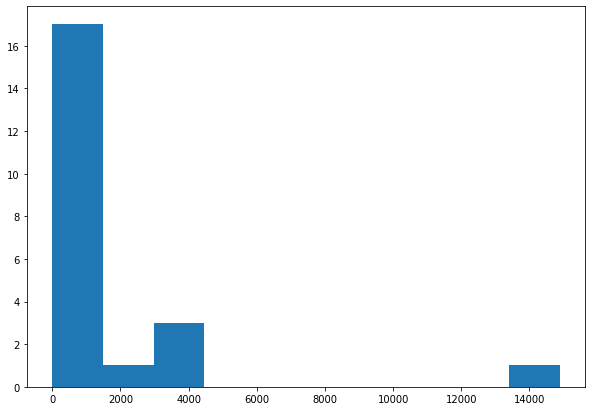

In [ ]:
img = cv2.imread('F:/CEERI/Outex-TC-00010/images/002608.bmp')
img = np.array(img)
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
height, width = np.shape(img)
out_filtered = np.zeros(np.shape(img), dtype=np.uint8)
# print(out_filtered)
cv2.imshow('img',img)
cv2.waitKey(0) 
#closing all open windows 
cv2.destroyAllWindows() 
img_gray = median_filter(img,3,1,out_filtered)
combined_hist = calculate_relbp(img_gray)

# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(combined_hist, bins = p+2)

# Show plot
plt.show()

In [ ]:
combined_hist

array([    9,     0,   282,  2520,  4429,     0,  3346,   354,     0,
           1,     0,  3952,     0,     0,     0,     0,     0, 14884,
           0,     0,     0,     0])

In [ ]:
combined_hist

array([    5,     4,     2,   491,  4037,  4245,     0,  1937,   128,
           0,     0,  4044,     0,     0,     0,     0,     0, 14884,
           0,     0,     0,     0])

In [ ]:
combined_hist

array([    0,     9,   608,  3820,  3719,     0,  2087,   191,     0,
           0,     0,  4459,     0,     0,     0,     0,     0, 14884,
           0,     0,     0,     0])

In [52]:
database = 'C:/Users/bits/Desktop/PS1_DATASET/OUTEX/Outex-TC-00010/000/'

mrelbp_hist = []

labels = []
result_labels_and_hist = []


result_SVM_labels_mrelbp_hist = []
result_NB_labels_mrelbp_hist = []
result_LR_labels_mrelbp_hist = []

SVM_classifier_mrelbp = make_pipeline(StandardScaler(), SVC(gamma='auto'))
NB_classifier_mrelbp = MultinomialNB()
LR_classifier_mrelbp = LogisticRegression(random_state=0)




# classes
with open(database + "classes.txt", "r") as file:
    numClasses = int(file.readline())
    classes = {}
    for line in file:
        columns = line.split()
        classes[int(columns[1])] = columns[0]



# Train
print("Training steps:")
with open(database + "test.txt", "r") as train:
    with open(database + "test_files.txt", "r") as trainFiles:
        numTrain = int(train.readline())
        i = 0
        for pathFile in trainFiles:
#             if i==0:
#                 pathFile = pathFile[3:]
            print(pathFile)
            
            img = cv2.imread(pathFile.rstrip(), cv2.IMREAD_GRAYSCALE)
            height, width = np.shape(img)
            out_filtered = np.zeros(np.shape(img), dtype=np.uint8)
            # print(out_filtered)
            # cv2.imshow('img',img)
            # cv2.waitKey(0) 
            # #closing all open windows 
            # cv2.destroyAllWindows() 
            img_gray = median_filter(img,3,1,out_filtered)
            combined_hist = calculate_relbp(img_gray)
            mrelbp_hist.append(combined_hist)
            labels.append(train.readline().split()[1])
            print(i)
            i+=1
            if i >= numTrain:
                break


Training steps:
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000020.bmp

0
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000021.bmp

1
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000022.bmp

2
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000023.bmp

3
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000024.bmp

4
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000025.bmp

5
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000026.bmp

6
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000027.bmp

7
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000028.bmp

8
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000029.bmp

9
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000030.bmp

10
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000031.bmp

11
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000032.b

In [82]:
KNN_classifier_mrelbp = KNeighborsClassifier(n_neighbors=9, weights='uniform', algorithm='auto', metric=chiSquared)
result_KNN_labels_mrelbp_hist = []
# fitting
print("Fitting the models")

# model = KNeighborsClassifier(n_neighbors = 1, weights='uniform', algorithm='auto', metric=chiSquared)
# model.fit(data,labels)
KNN_classifier_mrelbp.fit(mrelbp_hist,labels)
SVM_classifier_mrelbp.fit(mrelbp_hist,labels)
NB_classifier_mrelbp.fit(mrelbp_hist,labels)
LR_classifier_mrelbp.fit(mrelbp_hist,labels)


Fitting the models


C:\Users\bits\miniconda3\envs\GPU_TF_PY3-7\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(random_state=0)

In [54]:
# test
print("Testing steps:")
with open(database + "train.txt", "r") as test:
    with open(database + "train_files.txt", "r") as testFiles:
        
        numTest = int(test.readline())
        i = 0
        for pathFile in testFiles:
#             if i<155:
#                 print('[IGNORE] : ',test.readline(),'on path:', pathFile)
#                 i+=1
#                 continue
            print(pathFile)
            img = cv2.imread(pathFile.rstrip(), cv2.IMREAD_GRAYSCALE)
            height, width = np.shape(img)
            out_filtered = np.zeros(np.shape(img), dtype=np.uint8)
            # print(out_filtered)
            # cv2.imshow('img',img)
            # cv2.waitKey(0) 
            # #closing all open windows 
            # cv2.destroyAllWindows() 
            img_gray = median_filter(img,3,1,out_filtered)
            combined_hist = calculate_relbp(img_gray)
            result_labels_and_hist.append((test.readline().split()[1],combined_hist))
            
            print(i)
            i+=1
            if i >= numTest:
                break
                


        

Testing steps:
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000000.bmp

0
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000001.bmp

1
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000002.bmp

2
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000003.bmp

3
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000004.bmp

4
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000005.bmp

5
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000006.bmp

6
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000007.bmp

7
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000008.bmp

8
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000009.bmp

9
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000010.bmp

10
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000011.bmp

11
C:\Users\bits\Desktop\PS1_DATASET\OUTEX\Outex-TC-00010\images\000012.bm

In [74]:

for m in range(480):
    result_SVM_labels_mrelbp_hist.append((result_labels_and_hist[m][0],
                  SVM_classifier_mrelbp.predict([result_labels_and_hist[m][1].tolist()])))
    result_NB_labels_mrelbp_hist.append((result_labels_and_hist[m][0],
                  NB_classifier_mrelbp.predict([result_labels_and_hist[m][1].tolist()])))
    result_LR_labels_mrelbp_hist.append((result_labels_and_hist[m][0],
                  LR_classifier_mrelbp.predict([result_labels_and_hist[m][1].tolist()])))
    result_KNN_labels_mrelbp_hist.append((result_labels_and_hist[m][0],
                  KNN_classifier_mrelbp.predict([result_labels_and_hist[m][1].tolist()])))

In [83]:
for k in range(480):
    result_KNN_labels_mrelbp_hist.append((result_labels_and_hist[m][0],
                  KNN_classifier_mrelbp.predict([result_labels_and_hist[m][1].tolist()])))

In [75]:
#KNN(neighbours = 1) results on MRELBP
pred = 0
numTest = np.shape(combined_hist)[0]
for j in range(480):
    pred += (int(result_KNN_labels_mrelbp_hist[j][0] == result_KNN_labels_mrelbp_hist[j][1][0]))
    
print('predictions =',pred)
print('accuracy =',pred/(480)*100)

predictions = 423
accuracy = 88.125


In [72]:
#KNN(neighbours = 3) results on MRELBP
pred = 0
numTest = np.shape(combined_hist)[0]
for j in range(480):
    pred += (int(result_KNN_labels_mrelbp_hist[j][0] == result_KNN_labels_mrelbp_hist[j][1][0]))
    
print('predictions =',pred)
print('accuracy =',pred/(480)*100)

predictions = 430
accuracy = 89.58333333333334


In [69]:
#KNN(neighbours = 5) results on MRELBP
pred = 0
numTest = np.shape(combined_hist)[0]
for j in range(480):
    pred += (int(result_KNN_labels_mrelbp_hist[j][0] == result_KNN_labels_mrelbp_hist[j][1][0]))
    
print('predictions =',pred)
print('accuracy =',pred/(480)*100)

predictions = 423
accuracy = 88.125


In [81]:
#KNN(neighbours = 7) results on MRELBP
pred = 0
numTest = np.shape(combined_hist)[0]
for j in range(480):
    pred += (int(result_KNN_labels_mrelbp_hist[j][0] == result_KNN_labels_mrelbp_hist[j][1][0]))
    
print('predictions =',pred)
print('accuracy =',pred/(480)*100)

predictions = 480
accuracy = 100.0


In [84]:
#KNN(neighbours = 9) results on MRELBP
pred = 0
numTest = np.shape(combined_hist)[0]
for j in range(480):
    pred += (int(result_KNN_labels_mrelbp_hist[j][0] == result_KNN_labels_mrelbp_hist[j][1][0]))
    
print('predictions =',pred)
print('accuracy =',pred/(480)*100)

predictions = 480
accuracy = 100.0


In [56]:
#SVM results on MRELBP
pred = 0
numTest = np.shape(combined_hist)[0]
for j in range(480):
    pred += (int(result_SVM_labels_mrelbp_hist[j][0] == result_SVM_labels_mrelbp_hist[j][1][0]))
    
print('predictions =',pred)
print('accuracy =',pred/(480)*100)


predictions = 340
accuracy = 70.83333333333334


In [57]:

#NB results on MRELBP
pred = 0
numTest = np.shape(combined_hist)[0]
for j in range(480):
    pred += (int(result_NB_labels_mrelbp_hist[j][0] == result_NB_labels_mrelbp_hist[j][1][0]))
    
print('predictions =',pred)
print('accuracy =',pred/(480)*100)


predictions = 148
accuracy = 30.833333333333336


In [58]:
#LR results on MRELBP
pred = 0
numTest = np.shape(combined_hist)[0]
for j in range(480):
    pred += (int(result_LR_labels_mrelbp_hist[j][0] == result_LR_labels_mrelbp_hist[j][1][0]))
    
print('predictions =',pred)
print('accuracy =',pred/(480)*100)


predictions = 344
accuracy = 71.66666666666667
